import libraries

In [159]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm

function to map polygon to image masks - training data

In [160]:
images_dir = "./dataset/train/images"
labels_dir = "./dataset/train/labels"
masks_dir = "./dataset/train/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

function to map polygon to image masks - validation data

In [161]:
images_dir = "./dataset/valid/images"
labels_dir = "./dataset/valid/labels"
masks_dir = "./dataset/valid/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

show example data

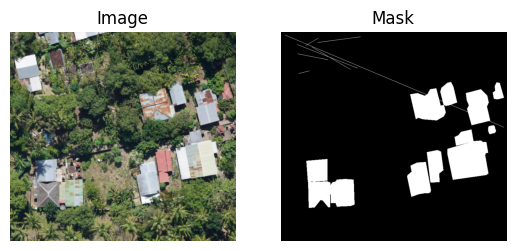

In [162]:
img = cv2.imread('./dataset/valid/images/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./dataset/valid/output_masks/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.png', cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title('Mask')
plt.show()

segmentation dataset

In [163]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found or could not be opened: {mask_path}")

        mask = (mask == 1).astype('float32')
        
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

albumentation

In [164]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])

data load

In [165]:
train_dataset = SegmentationDataset(
    images_dir='./dataset/train/images',
    masks_dir='./dataset/train/output_masks',
    transform=train_transform
)
valid_dataset = SegmentationDataset(
    images_dir='./dataset/valid/images',
    masks_dir='./dataset/valid/output_masks',
    transform=valid_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

dice loss

In [166]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits = torch.sigmoid(logits)
        logits = logits.view(-1)
        targets = targets.view(-1)

        intersection = (logits * targets).sum()
        dice = (2. * intersection + self.smooth) / (logits.sum() + targets.sum() + self.smooth)
        return 1 - dice

define model

In [167]:
from segmentation_models_pytorch.losses import JaccardLoss

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",        
    encoder_weights="imagenet",     
    in_channels=3,
    classes=1,                   
)
loss_fn = lambda logits, targets: 0.5 * nn.BCEWithLogitsLoss()(logits, targets) + 0.5 * JaccardLoss(mode='binary')(logits, targets)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train the data

In [168]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
epochs_input = 15

train_losses = []
val_losses = []
ious = []

jaccard = BinaryJaccardIndex().to(device)
best_score = 0.0

for epoch in range(epochs_input):
    print(f"\nEpoch [{epoch+1}/{epochs_input}]")

    # --- Training ---
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        try:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)   
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        except Exception as e:
            print(f"Error in training batch: {e}")

    avg_train_loss = train_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss:.4f}")

    model.eval()
    jaccard.reset()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc="Validating", leave=False):
            try:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).int()
                true_masks = masks.int()
                
                print("Preds unique:", torch.unique(preds))  
                print("Masks unique:", torch.unique(masks))  

                jaccard.update(preds, true_masks)

            except Exception as e:
                print(f"Error in validation batch: {e}")


    avg_val_loss = val_loss / len(valid_loader)
    epoch_iou = jaccard.compute().item()
    print(f"Validation Loss: {avg_val_loss:.4f} | IoU: {epoch_iou:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    ious.append(epoch_iou)

    if epoch_iou > best_score:
        best_score = epoch_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved.")


Epoch [1/15]


Training Loss: 0.3048


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:13<00:01,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.3866 | IoU: 0.6069
✅ Best model saved.

Epoch [2/15]


Training Loss: 0.2159


Validating:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4007 | IoU: 0.6098
✅ Best model saved.

Epoch [3/15]


Training Loss: 0.1886


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.26s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.25s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:08,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.26s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:08<00:05,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.3833 | IoU: 0.6212
✅ Best model saved.

Epoch [4/15]


Training Loss: 0.1727


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.34s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:13<00:01,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4592 | IoU: 0.6269
✅ Best model saved.

Epoch [5/15]


Training Loss: 0.1495


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.26s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.25s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4148 | IoU: 0.6415
✅ Best model saved.

Epoch [6/15]


Training Loss: 0.1566


Validating:   9%|▉         | 1/11 [00:01<00:13,  1.36s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:04<00:11,  1.39s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.37s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:08,  1.36s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:08<00:06,  1.35s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.37s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:04,  1.36s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:12<00:02,  1.35s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.3974 | IoU: 0.6458
✅ Best model saved.

Epoch [7/15]


Training Loss: 0.1532


Validating:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4192 | IoU: 0.6482
✅ Best model saved.

Epoch [8/15]


Training Loss: 0.1432


Validating:   9%|▉         | 1/11 [00:01<00:13,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:04<00:10,  1.36s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.41s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:08,  1.39s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:08<00:06,  1.37s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.35s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:04,  1.38s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:12<00:02,  1.36s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4416 | IoU: 0.6436

Epoch [9/15]


Training Loss: 0.1325


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.34s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.34s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:13<00:01,  1.32s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4273 | IoU: 0.6466

Epoch [10/15]


Training Loss: 0.1378


Validating:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.34s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:13<00:01,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.3818 | IoU: 0.6440

Epoch [11/15]


Training Loss: 0.1257


Validating:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.33s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4321 | IoU: 0.6434

Epoch [12/15]


Training Loss: 0.1241


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.24s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.24s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:08,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:08<00:05,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4128 | IoU: 0.6502
✅ Best model saved.

Epoch [13/15]


Training Loss: 0.1248


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.25s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:09<00:05,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4624 | IoU: 0.6489

Epoch [14/15]


Training Loss: 0.1134


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.26s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.30s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.27s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:08<00:05,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4158 | IoU: 0.6494

Epoch [15/15]


Training Loss: 0.1109


Validating:   9%|▉         | 1/11 [00:01<00:12,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  18%|█▊        | 2/11 [00:02<00:11,  1.26s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  27%|██▋       | 3/11 [00:03<00:10,  1.31s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  36%|███▋      | 4/11 [00:05<00:09,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  45%|████▌     | 5/11 [00:06<00:07,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  55%|█████▍    | 6/11 [00:07<00:06,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  64%|██████▎   | 7/11 [00:08<00:05,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  73%|███████▎  | 8/11 [00:10<00:03,  1.29s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  82%|████████▏ | 9/11 [00:11<00:02,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Validating:  91%|█████████ | 10/11 [00:12<00:01,  1.28s/it]

Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])


Preds unique: tensor([0, 1], dtype=torch.int32)
Masks unique: tensor([0., 1.])
Validation Loss: 0.4081 | IoU: 0.6523
✅ Best model saved.


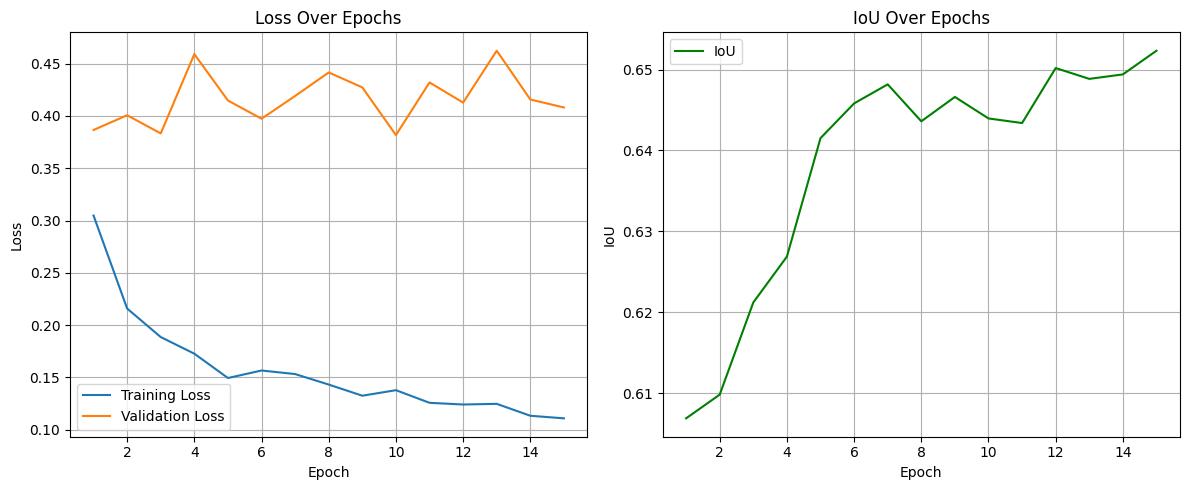

In [169]:
import matplotlib.pyplot as plt

epochs = range(1, epochs_input + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, ious, label='IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [170]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding):

In [177]:
images_dir = "./dataset/test/images"
labels_dir = "./dataset/test/labels"
masks_dir = "./dataset/test/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue

    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)

    cv2.imwrite(mask_path, mask)


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

class TestSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __getitem__(self, idx):
        img_name = self.images[idx]  
        img_path = os.path.join(self.image_dir, img_name) 

        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found or could not be opened: {mask_path}")

        mask = (mask == 1).astype('float32')

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, torch.tensor(mask).unsqueeze(0)

    def __len__(self):
        return len(self.images)


In [ ]:
test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])


In [184]:
from torch.utils.data import DataLoader
import torch
import segmentation_models_pytorch as smp

# Load model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
model.eval().to(device)

# Load test set
test_dataset = TestSegmentationDataset(
    image_dir="./dataset/test/images",
    mask_dir="./dataset/test/output_masks",
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate
from torchmetrics.classification import BinaryJaccardIndex

jaccard = BinaryJaccardIndex().to(device)
model.eval()
jaccard.reset()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        jaccard.update(preds, masks.int())

test_iou = jaccard.compute().item()
print(f"✅ Test IoU: {test_iou:.4f}")


C:\Users\hg\AppData\Local\Temp\ipykernel_1356\3904497752.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask).unsqueeze(0)  # [1, H, W]


✅ Test IoU: 0.9013


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def denormalize(image_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return (image_tensor * std + mean).clamp(0, 1)

def visualize_prediction(model, test_loader, device, num_samples=5):
    model.eval()
    model.to(device)

    count = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                img_tensor = images[i].cpu()
                img_denorm = denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                image_np = img_denorm.permute(1, 2, 0).numpy()

                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds[i].cpu().squeeze().numpy()

                if mask_np.ndim != 2:
                    mask_np = mask_np[0]
                if pred_np.ndim != 2:
                    pred_np = pred_np[0]

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image_np)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(mask_np, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred_np, cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                count += 1
                if count >= num_samples:
                    return


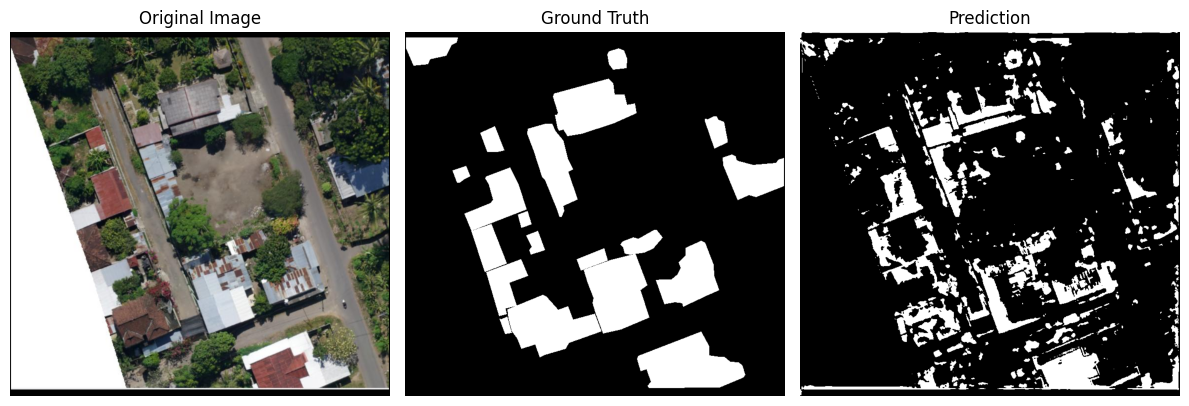

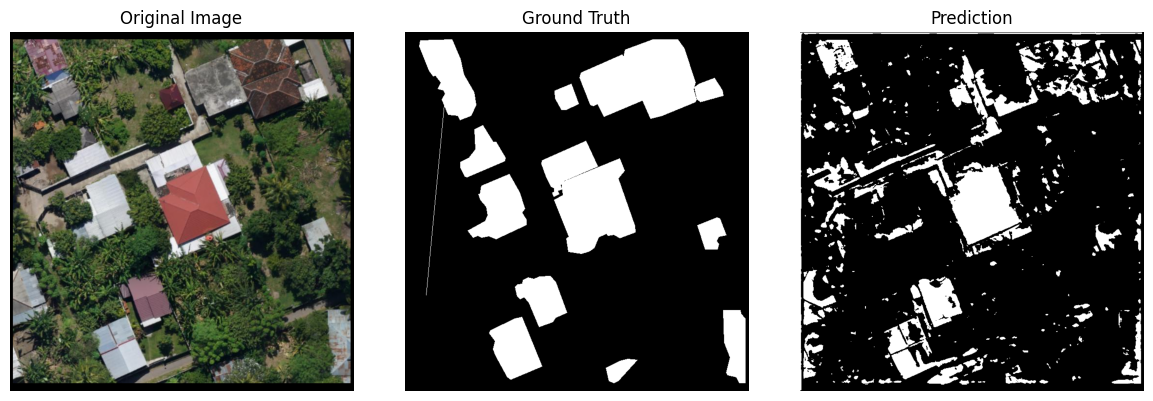

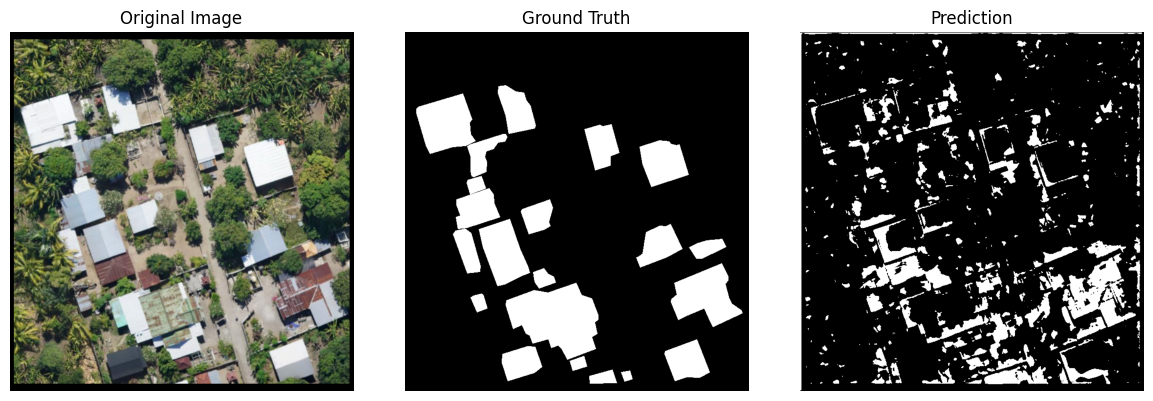

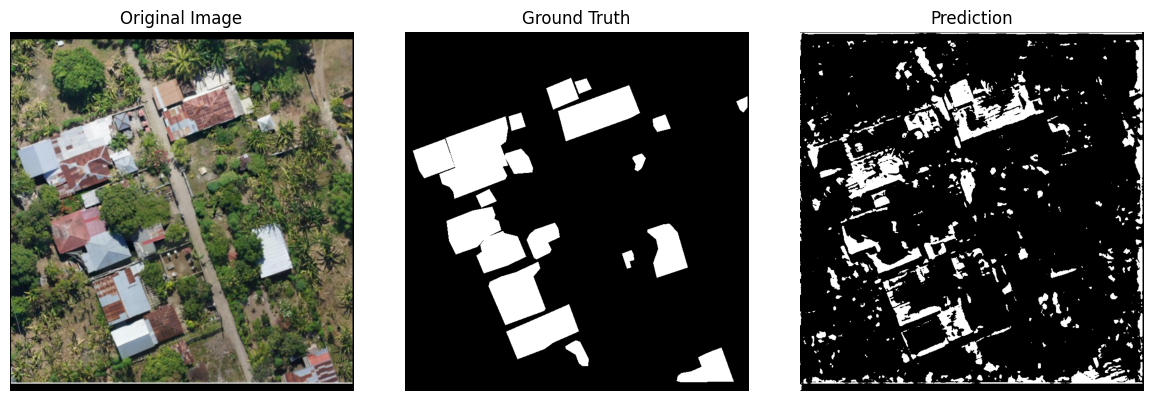

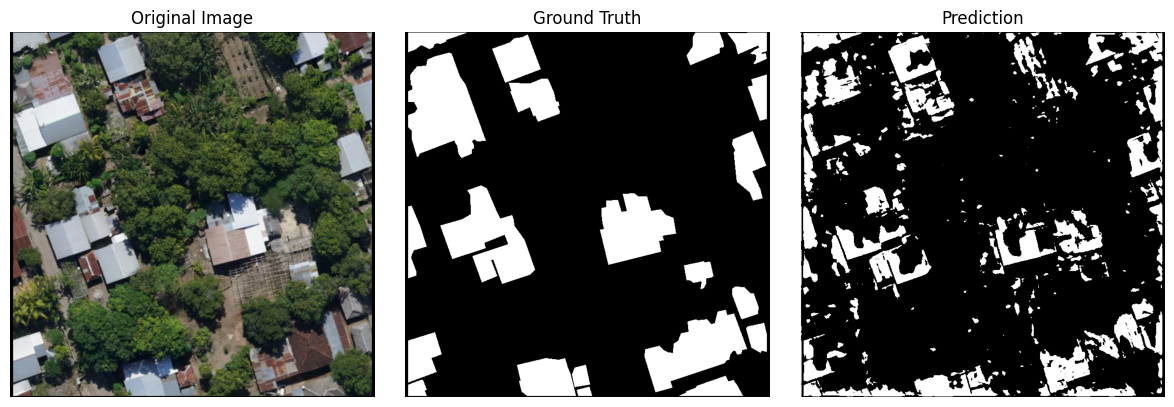

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_prediction(model, test_loader, device, num_samples=5)
